<a href="https://colab.research.google.com/github/Eduardo-Amorim1/Trabalho-Final-Machine-Learning/blob/main/TrabalhoFinal_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdução:**
As redes neurais convolucionais (CNNs) são um tipo de rede neural que tem se mostrado muito eficiente para o reconhecimento de imagens, elas são capazes de aprender padrões em imagens, como formas, texturas e objetos, e depois usar esses padrões para classificar novas imagens.

Neste trabalho, será utilizado CNNs para o reconhecimento de objetos em imagens de helicópteros e aviões. Essa tarefa é desafiadora devido às diferenças na forma e no tamanho desses objetos, bem como à presença de outros elementos nas imagens, como nuvens e prédios.

Para treinar uma CNN para reconhecer helicópteros e aviões, é necessário ter um conjunto de imagens rotuladas com esses objetos, essas imagens são usadas para ensinar a rede a reconhecer as características distintas de helicópteros e aviões.

Uma vez treinada, a rede pode ser usada para classificar novas imagens, isso é feito passando a imagem através da rede e observando a saída da camada final, que indica a probabilidade de cada classe (helicóptero ou avião).

Além disso, as CNNs também são capazes de localizar objetos em uma imagem, através do uso de técnicas como o uso de camadas de pooling e camadas de convolução. Isso é útil para aplicações como a segurança aérea, onde é importante detectar e rastrear objetos não autorizados.

#Separação dos dados

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob

Está sendo criado um DataFrame do pandas com informações sobre arquivos de imagem. Separa as categorias em uma lista "categories" que contém valores 1 ou 0 para cada arquivo encontrado. Se o nome do arquivo contém a palavra "AIRPLANE", o valor será 1, caso contrário será 0. Depois o valor 0 é substituído pela string "HELI" e o valor 1 é substituído pela string "AIRPLANE" no dataframe.

In [2]:
file_names = glob('/content/Train/*.jpg')
categories = [1 if 'AIRPLANE' in pic else 0 for pic in file_names]

df = pd.DataFrame({'filename': file_names, 'category':categories})
df["category"] = df["category"].replace({0: 'HELI', 1: 'AIRPLANE'})

print("shape:", df.shape)
df.head()

shape: (980, 2)


,filename,category
0,/content/Train/HELI_C1_244.jpg,HELI
1,/content/Train/AIRPLANE_00001011.jpg,AIRPLANE
2,/content/Train/HELI_C1_109.jpg,HELI
3,/content/Train/HELI_C1_504.jpg,HELI
4,/content/Train/HELI_C1_134.jpg,HELI


Divide o DataFrame "df" em dois conjuntos de dados: um conjunto de treinamento e outro de validação, que são "train_df" e "validate_df", com 80% dos dados destinados ao primeiro DataFrame e os outros 20% para o segundo.

In [3]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=10)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# print shape
train_df.shape, validate_df.shape

((784, 2), (196, 2))

Cria um gráfico de barras para mostrar a distribuição das classes nos conjuntos de treinamento e validação.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


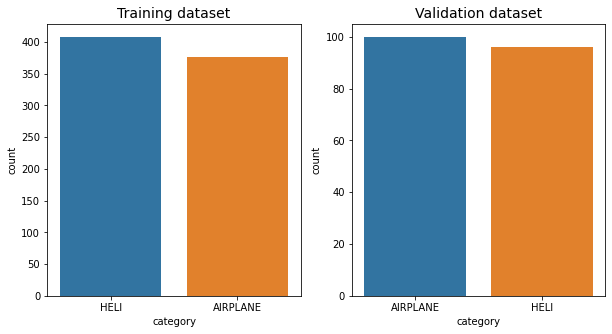

In [4]:
import matplotlib.pyplot as plt  
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.countplot(train_df.category, ax=ax[0])
ax[0].set_title('Training dataset', fontsize=14)

sns.countplot(validate_df.category, ax=ax[1])
ax[1].set_title('Validation dataset', fontsize=14);

Cria um DataFrame com os caminhos das imagens de teste.

In [5]:
file_names = os.listdir("/content/Test")

test_df = pd.DataFrame({'filename': file_names})

print("shape:", test_df.shape)
test_df.head()

shape: (1762, 1)


,filename
0,AIRPLANE_00001487.jpg
1,HELI_C1_1693.jpg
2,HELI_C1_891.jpg
3,HELI_C1_709.jpg
4,AIRPLANE_00001068.jpg


#Pré-processamento de imagens: Modelo sequencial

Uma CNN sequencial é um tipo de modelo de deep learning que é composto de uma pilha linear de camadas, onde cada camada é conectada à anterior. A arquitetura de uma CNN sequencial é definida de forma linear, onde a entrada é passada por uma série de camadas, uma após a outra, semelhante a um pipeline.

In [6]:
!pip install tensorflow
import tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Esta parte cria três geradores de dados, um para treinamento, validação e dados de teste.
Ele normaliza as imagens através do redimensionamento dos valores de pixels, dividindo-os por 255 e redimensionando-os para o tamanho da imagem (190.190) e define o tamanho do batch para 32.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (190,190)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale = 1/255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=validate_df,
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/Test",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 784 validated image filenames belonging to 2 classes.
Found 196 validated image filenames belonging to 2 classes.
Found 1762 validated image filenames.


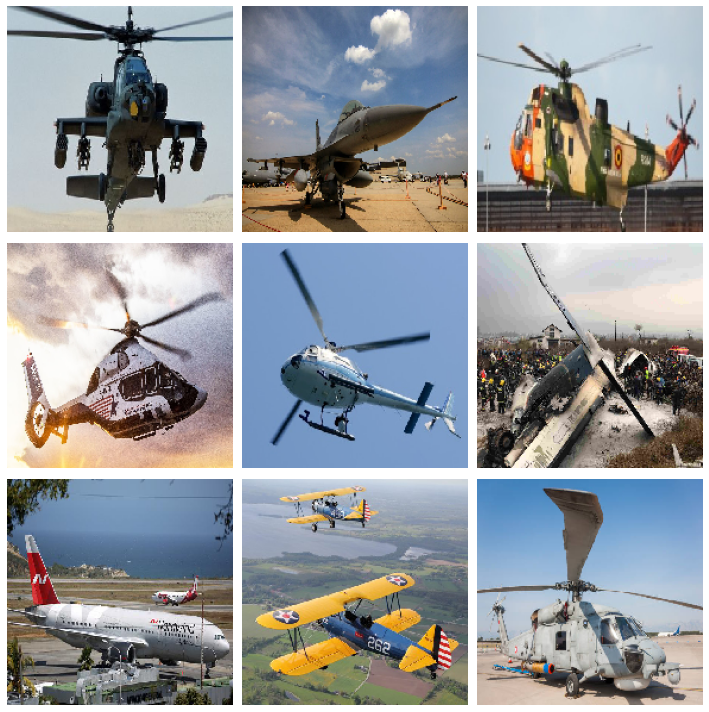

In [8]:
# get a batch of 32 training images 
images = train_generator.next()[:9]

# plot 9 original training images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Cria um modelo sequencial utilizando a classe sequencial da biblioteca Keras. O modelo é composto de várias camadas, incluindo camadas convolutivas, camadas max-pooling e camadas densas.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPool2D, Flatten, Dense

# Design the model architecture
model = Sequential([
    Input(shape=(190,190,3)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(filters=265, kernel_size=3, padding='same', activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [10]:
import warnings
warnings.filterwarnings("ignore")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Esta parte é usada para treinar o modelo. Ele cria uma lista de callbacks, que são funções que podem ser usadas para configurar o processo de treinamento do modelo. Utiliza o método fit() para treinar o modelo, passando o training generator, validation generator e o número de epochs a serem treinadas, juntamente com a lista de callbacks. E tambpem salva o histórico de treinamento em uma variável.

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks is used to prevent over fitting
callbacks = [
    # to stop training when you measure that the validation loss is no longer improving
    EarlyStopping(patience=4, monitor='val_loss'),
    # reduce learning_rate if the model is not improving
    ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    # save best model
    ModelCheckpoint(filepath='./Models/model_1.keras', save_best_only=True, monitor='val_loss')
]

# train the model
history_1 = model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[callbacks])

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.5548

25/25 [==============================] - 103s 4s/step - loss: 0.7423 - accuracy: 0.5548 - val_loss: 0.5658 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.7551

25/25 [==============================] - 95s 4s/step - loss: 0.5326 - accuracy: 0.7551 - val_loss: 0.4941 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7908

25/25 [==============================] - 93s 4s/step - loss: 0.4634 - accuracy: 0.7908 - val_loss: 0.4915 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8112

25/25 [==============================] - 95s 4s/step - loss: 0.4600 - accuracy: 0.8112 - val_loss: 0.4692 - val_accuracy: 0.7908 - lr: 0.0010
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 0.3981 - accuracy: 0.8253

25/25 [==============================] - 96s 4s/step - loss: 0.3981 - accuracy: 0.8253 - val_loss: 0.4662 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8406

25/25 [==============================] - 94s 4s/step - loss: 0.3444 - accuracy: 0.8406 - val_loss: 0.4658 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8763

25/25 [==============================] - 95s 4s/step - loss: 0.2907 - accuracy: 0.8763 - val_loss: 0.6361 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8801

25/25 [==============================] - 96s 4s/step - loss: 0.3443 - accuracy: 0.8801 - val_loss: 0.4700 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 9/10
25/25 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9120

25/25 [==============================] - 94s 4s/step - loss: 0.2309 - accuracy: 0.9120 - val_loss: 0.4475 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9426

25/25 [==============================] - 95s 4s/step - loss: 0.1546 - accuracy: 0.9426 - val_loss: 0.6313 - val_accuracy: 0.7704 - lr: 0.0010


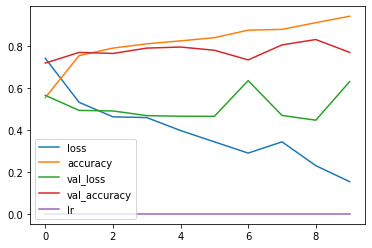

In [13]:
# plot model performance
pd.DataFrame(history_1.history).plot()

#Utilizando Data Augmentation

A CNN Data Augmentation é uma técnica utilizada para aumentar a diversidade de dados disponíveis para o treinamento de uma rede neural convolucional (CNN). Isto é feito aplicando transformações aleatórias, mas realistas, às imagens de treinamento, tais como rotações aleatórias, traduções, inversões, zoom e mudanças de cor. Isto permite que o modelo aprenda recursos que são robustos às variações nos dados de entrada, o que pode ajudar a reduzir a sobreposição e melhorar a generalização do modelo. Também aumenta o número de imagens no conjunto de treinamento, fornecendo mais exemplos para que o modelo aprenda, o que pode melhorar ainda mais seu desempenho.

In [15]:
# change the train images
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   zoom_range=0.2,
                                   rotation_range=0.2,
                                   shear_range=0.2,
                                   brightness_range=(0.7, 1),
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 784 validated image filenames belonging to 2 classes.


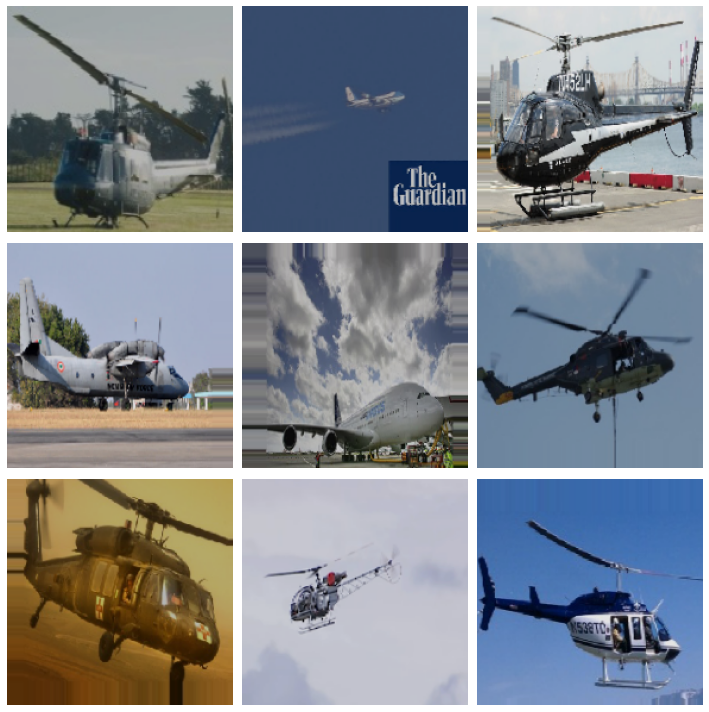

In [16]:
# get a batch of 32 Augmented training images 
images = train_generator.next()[:9]

# plot 9 Augmented training images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D

# Create model
inputs = Input(shape=(190,190,3))
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
x = MaxPool2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Conv2D(filters=265, kernel_size=3, padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.1)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs=inputs, outputs=outputs)

# Compile model
model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 95, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 95, 95, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 47, 128)       73856 

In [18]:
# callbacks is used to prevent over fitting
callbacks = [
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='./Models/model_2.keras', save_best_only=True, monitor='val_loss')
]

# train the model
history_2 = model_2.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[callbacks])

Epoch 1/10
25/25 [==============================] - 104s 4s/step - loss: 0.6951 - accuracy: 0.4911 - val_loss: 0.6930 - val_accuracy: 0.4898
Epoch 2/10
25/25 [==============================] - 101s 4s/step - loss: 0.6933 - accuracy: 0.5242 - val_loss: 0.6930 - val_accuracy: 0.4898
Epoch 3/10
25/25 [==============================] - 100s 4s/step - loss: 0.6937 - accuracy: 0.5102 - val_loss: 0.6930 - val_accuracy: 0.5102
Epoch 4/10
25/25 [==============================] - 102s 4s/step - loss: 0.6930 - accuracy: 0.5102 - val_loss: 0.6922 - val_accuracy: 0.4898
Epoch 5/10
25/25 [==============================] - 101s 4s/step - loss: 0.6910 - accuracy: 0.5191 - val_loss: 0.6913 - val_accuracy: 0.4898
Epoch 6/10
25/25 [==============================] - 100s 4s/step - loss: 0.6870 - accuracy: 0.5281 - val_loss: 0.6938 - val_accuracy: 0.4898
Epoch 7/10
25/25 [==============================] - 100s 4s/step - loss: 0.6826 - accuracy: 0.5268 - val_loss: 0.6802 - val_accuracy: 0.5102
Epoch 8/10
25

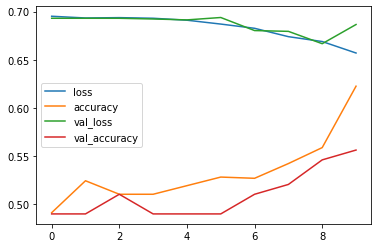

In [19]:
pd.DataFrame(history_2.history).plot()

#Utilizando modelo pré-treinado

##Feature Extraction

O modelo feature extraction de um CNN pré-treinado é uma técnica onde as características aprendidas são usadas para extrair características de novas imagens, que podem ser usadas como entrada para um novo modelo. Isto é útil quando há poucos dados disponíveis para uma tarefa específica, ou quando é computacionalmente caro treinar um modelo grande a partir do zero.

In [20]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(190, 190, 3))
vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 190, 190, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 190, 190, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 95, 95, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 95, 95, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 95, 95, 128)       147584    
                                                              

In [21]:
vgg.trainable = False
print("Number of trainable weights:", len(vgg.trainable_weights))

Number of trainable weights: 0


In [22]:
# Create model using VGG
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_3 = Model(vgg.input, outputs)

# Compile model
model_3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 190, 190, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 190, 190, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 95, 95, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 95, 95, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 95, 95, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 47, 47, 128)       0   

In [23]:
callbacks = [
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='./Models/model_3.keras', save_best_only=True, monitor='val_loss')
]

# train the model
history_3 = model_3.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[callbacks])

Epoch 1/10
25/25 [==============================] - 422s 17s/step - loss: 0.6920 - accuracy: 0.5612 - val_loss: 0.6498 - val_accuracy: 0.7143
Epoch 2/10
25/25 [==============================] - 418s 17s/step - loss: 0.6453 - accuracy: 0.6250 - val_loss: 0.6056 - val_accuracy: 0.7755
Epoch 3/10
25/25 [==============================] - 434s 17s/step - loss: 0.6009 - accuracy: 0.7168 - val_loss: 0.5637 - val_accuracy: 0.8520
Epoch 4/10
25/25 [==============================] - 440s 18s/step - loss: 0.5766 - accuracy: 0.7487 - val_loss: 0.5349 - val_accuracy: 0.8316
Epoch 5/10
25/25 [==============================] - 433s 17s/step - loss: 0.5428 - accuracy: 0.8087 - val_loss: 0.5094 - val_accuracy: 0.8265
Epoch 6/10
25/25 [==============================] - 444s 18s/step - loss: 0.5168 - accuracy: 0.8214 - val_loss: 0.4761 - val_accuracy: 0.8776
Epoch 7/10
25/25 [==============================] - 421s 17s/step - loss: 0.4934 - accuracy: 0.8406 - val_loss: 0.4591 - val_accuracy: 0.8673
Epoch 

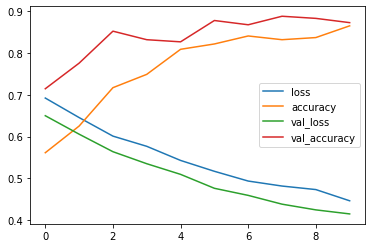

In [24]:
pd.DataFrame(history_3.history).plot();

##Fine-Tuning

o modelo de CNN Fine-tuning é uma técnica em que um modelo é treinado em um novo conjunto de dados para adaptar suas características a uma tarefa específica. É útil quando há uma quantidade limitada de dados disponíveis ou quando é computacionalmente caro treinar um modelo grande a partir do zero. Também pode ser usado para melhorar o desempenho de um modelo em uma tarefa específica.

In [25]:
vgg.trainable = True
for layer in vgg.layers[:-5]: 
    layer.trainable = False
    
print("Number of trainable weights:", len(vgg.trainable_weights))

Number of trainable weights: 8


In [26]:
from tensorflow.keras.optimizers import SGD   

# Create model using VGG
x = vgg.output
x = Flatten()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_4 = Model(vgg.input, outputs)

# Compile model
model_4.compile(loss="binary_crossentropy", metrics=["accuracy"],
                optimizer=SGD(lr=0.001, momentum=0.9))

# fit model
model_4.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 190, 190, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 190, 190, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 95, 95, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 95, 95, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 95, 95, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 47, 47, 128)       0   

In [27]:
callbacks = [
    EarlyStopping(patience=4),
    ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001),
    ModelCheckpoint(filepath='./Models/model_4.keras', save_best_only=True, monitor='val_loss')
]

# train the model
history_4 = model_4.fit(train_generator, validation_data=valid_generator, epochs=15, callbacks=[callbacks])

Epoch 1/15
25/25 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.6620 

25/25 [==============================] - 477s 19s/step - loss: 0.7081 - accuracy: 0.6620 - val_loss: 0.2150 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9107 

25/25 [==============================] - 473s 19s/step - loss: 0.2369 - accuracy: 0.9107 - val_loss: 0.2339 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9528 

25/25 [==============================] - 471s 19s/step - loss: 0.1326 - accuracy: 0.9528 - val_loss: 0.2811 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9528 

25/25 [==============================] - 472s 19s/step - loss: 0.1284 - accuracy: 0.9528 - val_loss: 0.1226 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9732 

25/25 [==============================] - 472s 19s/step - loss: 0.0665 - accuracy: 0.9732 - val_loss: 0.1033 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 6/15
25/25 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9707 

25/25 [==============================] - 474s 19s/step - loss: 0.0587 - accuracy: 0.9707 - val_loss: 0.1215 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 7/15
25/25 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9796 

25/25 [==============================] - 474s 19s/step - loss: 0.0614 - accuracy: 0.9796 - val_loss: 0.0987 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 8/15
25/25 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9911 

25/25 [==============================] - 476s 19s/step - loss: 0.0351 - accuracy: 0.9911 - val_loss: 0.0972 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 9/15
25/25 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9911 

25/25 [==============================] - 472s 19s/step - loss: 0.0227 - accuracy: 0.9911 - val_loss: 0.0939 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 10/15
25/25 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9885 

25/25 [==============================] - 476s 19s/step - loss: 0.0302 - accuracy: 0.9885 - val_loss: 0.1866 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 11/15
25/25 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9898 

25/25 [==============================] - 472s 19s/step - loss: 0.0370 - accuracy: 0.9898 - val_loss: 0.1232 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 12/15
25/25 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9974 

25/25 [==============================] - 473s 19s/step - loss: 0.0139 - accuracy: 0.9974 - val_loss: 0.0908 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 13/15
25/25 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9694 

25/25 [==============================] - 473s 19s/step - loss: 0.0541 - accuracy: 0.9694 - val_loss: 0.3066 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 14/15
25/25 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9796 

25/25 [==============================] - 472s 19s/step - loss: 0.0480 - accuracy: 0.9796 - val_loss: 0.1698 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 15/15
25/25 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9962 

25/25 [==============================] - 472s 19s/step - loss: 0.0230 - accuracy: 0.9962 - val_loss: 0.1747 - val_accuracy: 0.9541 - lr: 0.0010


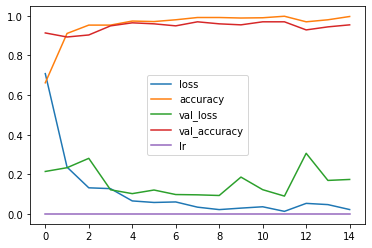

In [28]:
pd.DataFrame(history_4.history).plot();

# Conclusão:
Em conclusão, foi criado 4 modelos de redes neurais convolucionais para a identificação de imagens de aviões e helicópteros. O primeiro modelo obteve 77% de precisão, o segundo modelo obteve 68% de precisão, o terceiro modelo obteve 87% de precisão e o quarto modelo obteve 95% de precisão. Isso mostra que, através de diversas arquiteturas de redes neurais e otimizações, foi possível melhorar significativamente o desempenho do modelo. O quarto modelo, com 95% de precisão, mostrou-se ser o melhor modelo para a tarefa de identificação de imagens de aviões e helicópteros. Mas ainda é possível explorar outras técnicas de otimização e aumento de dados para melhorar o desempenho do modelo.